# Data

In [1]:
!git clone https://github.com/codessse/FOIS-py.git

Cloning into 'FOIS-py'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 131 (delta 84), reused 93 (delta 49), pack-reused 0
Receiving objects: 100% (131/131), 154.27 KiB | 3.96 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import json
from pprint import pprint


!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
from matplotlib.font_manager import fontManager
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2023-01-08 06:54:57--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.70.139, 74.125.70.113, 74.125.70.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.70.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i2kbg61tmvl07f6b4qsaq4e7hjik6p6b/1673160825000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=8fde8fdf-b03b-480b-9265-3c08eba6cc8e [following]
--2023-01-08 06:54:58--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i2kbg61tmvl07f6b4qsaq4e7hjik6p6b/1673160825000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=8fde8fdf-b03b-480b-9265-3c08eba6cc8e
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.193.132, 2607:f8b0:4001:c0f::84
Connecting to doc-0k-9o

In [3]:
os.chdir(r'/content/FOIS-py/dataset')
!ls

10月.csv  3月.csv  7月.csv	   covid_area_month.csv  lstm_data.csv
11月.csv  4月.csv  8月.csv	   covid_original.csv	 total_peo.csv
1月.csv   5月.csv  9月.csv	   covid_全區.csv
2月.csv   6月.csv  covid_area.csv  lstm_data2.csv


In [4]:
ori_data = pd.read_csv('lstm_data.csv')

ori_data

,日期,人數
0,2022-01-01,0
1,2022-01-02,1
2,2022-01-03,1
3,2022-01-04,1
4,2022-01-05,1
...,...,...
329,2022-11-26,1139
330,2022-11-27,877
331,2022-11-28,1470
332,2022-11-29,1590


# LSTM

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import load_model
from keras.utils import plot_model
import math

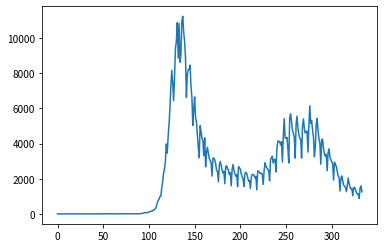

In [25]:
dataframe_ori = pd.read_csv('lstm_data.csv',encoding='utf8', usecols=[1], engine='python')
dataset = dataframe_ori.values
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

# 1

In [26]:
m = np.argmax(dataset)
dataset[m] = 0.5*(dataset[m-1]+dataset[m+1])
dataset_ori = dataset
np.random.seed(7)

scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)
train_data = dataset
# train_data, test_data = train_test_split(dataset, random_state=777, train_size=0.8)


In [27]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [28]:
look_back=1
trainX, trainY = create_dataset(train_data, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

Epoch 1/400
333/333 - 11s - loss: 0.0383 - 11s/epoch - 33ms/step
Epoch 2/400
333/333 - 2s - loss: 0.0113 - 2s/epoch - 6ms/step
Epoch 3/400
333/333 - 2s - loss: 0.0073 - 2s/epoch - 5ms/step
Epoch 4/400
333/333 - 2s - loss: 0.0062 - 2s/epoch - 5ms/step
Epoch 5/400
333/333 - 2s - loss: 0.0064 - 2s/epoch - 5ms/step
Epoch 6/400
333/333 - 2s - loss: 0.0075 - 2s/epoch - 5ms/step
Epoch 7/400
333/333 - 2s - loss: 0.0055 - 2s/epoch - 5ms/step
Epoch 8/400
333/333 - 2s - loss: 0.0062 - 2s/epoch - 6ms/step
Epoch 9/400
333/333 - 2s - loss: 0.0051 - 2s/epoch - 5ms/step
Epoch 10/400
333/333 - 2s - loss: 0.0047 - 2s/epoch - 5ms/step
Epoch 11/400
333/333 - 2s - loss: 0.0050 - 2s/epoch - 5ms/step
Epoch 12/400
333/333 - 2s - loss: 0.0053 - 2s/epoch - 6ms/step
Epoch 13/400
333/333 - 2s - loss: 0.0057 - 2s/epoch - 5ms/step
Epoch 14/400
333/333 - 2s - loss: 0.0049 - 2s/epoch - 5ms/step
Epoch 15/400
333/333 - 2s - loss: 0.0046 - 2s/epoch - 6ms/step
Epoch 16/400
333/333 - 2s - loss: 0.0051 - 2s/epoch - 5ms/ste

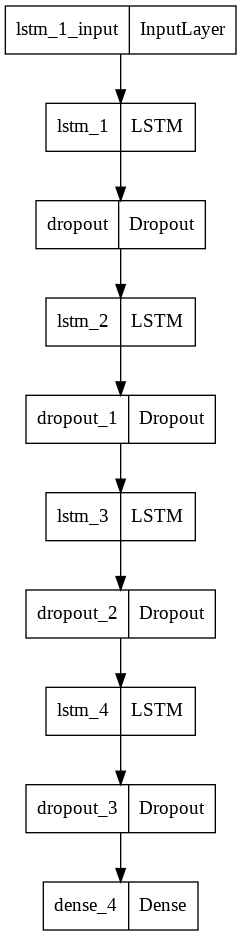

In [29]:

model = Sequential()
model.add(LSTM(units=50, input_shape=(1, look_back),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=10,mode='max')
train=model.fit(trainX, trainY, epochs=400, batch_size=1, verbose=2)
plot_model(model, 'model.png')  

In [30]:
model.save('my_model2.h5')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 50)               

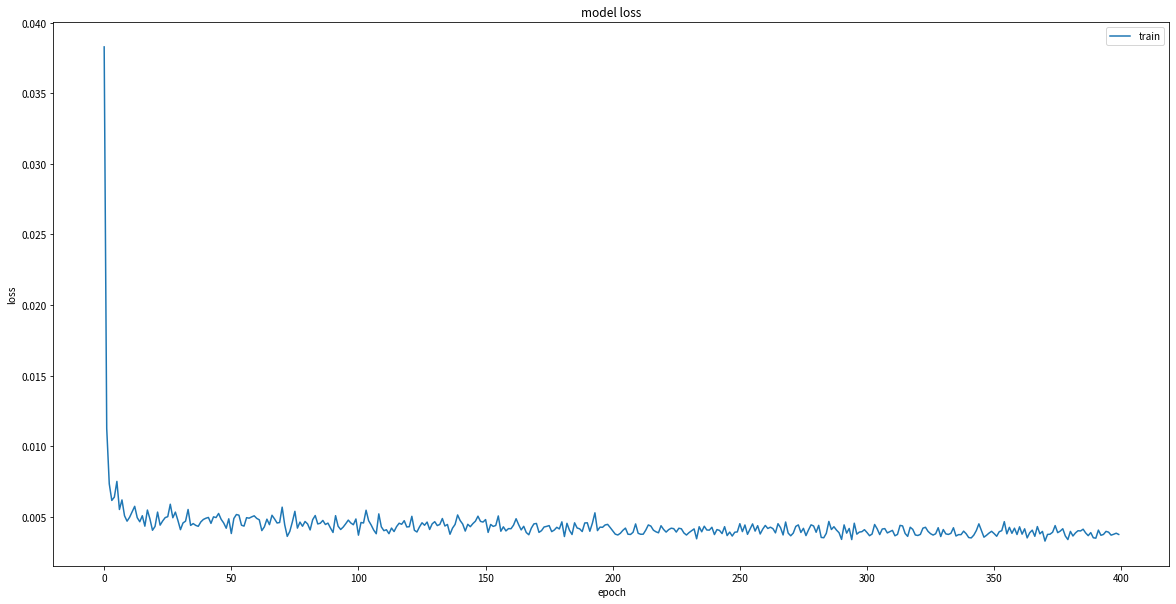

In [41]:
plt.figure(figsize=(20,10))
plt.plot(train.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

-------------------------------------------------------------------------------

In [26]:
model = load_model('my_model.h5')
trainX, trainY = create_dataset(train_data, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [33]:
trainPredict = model.predict(trainX)

11/11 [==============================] - 4s 126ms/step


In [34]:
predict_day=7
testx = [0.]*(predict_day+look_back)
testx[0:look_back] = train_data[-look_back:]
testx = np.array(testx,dtype=float)
testPredict = [0]*predict_day

<ipython-input-34-cc3ec0a7ee6d>:4: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  testx = np.array(testx,dtype=float)


In [35]:
for i in range(predict_day):
    testxx = testx[-look_back:]
    testxx = np.reshape(testxx, (1, 1, look_back))
    testy = model.predict(testxx)
    testx[look_back+i] = testy
    testPredict[i] = testy

1/1 [==============================] - 0s 30ms/step


In [36]:
testPredict = np.array(testPredict)
testPredict = np.reshape(testPredict,(predict_day,1))
# trainPredict = scaler.inverse_transform(trainPredict)

# trainY = (trainY.reshape(trainY.shape[0] * trainY.shape[1]))
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)

In [37]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 593.26 RMSE


In [38]:
trainPredictPlot = np.reshape(np.array([None]*(len(dataset)+predict_day)),((len(dataset)+predict_day),1))
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [39]:
testPredictPlot = np.reshape(np.array([None]*(len(dataset)+predict_day)),((len(dataset)+predict_day),1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(dataset):(len(dataset)+predict_day), :] = testPredict

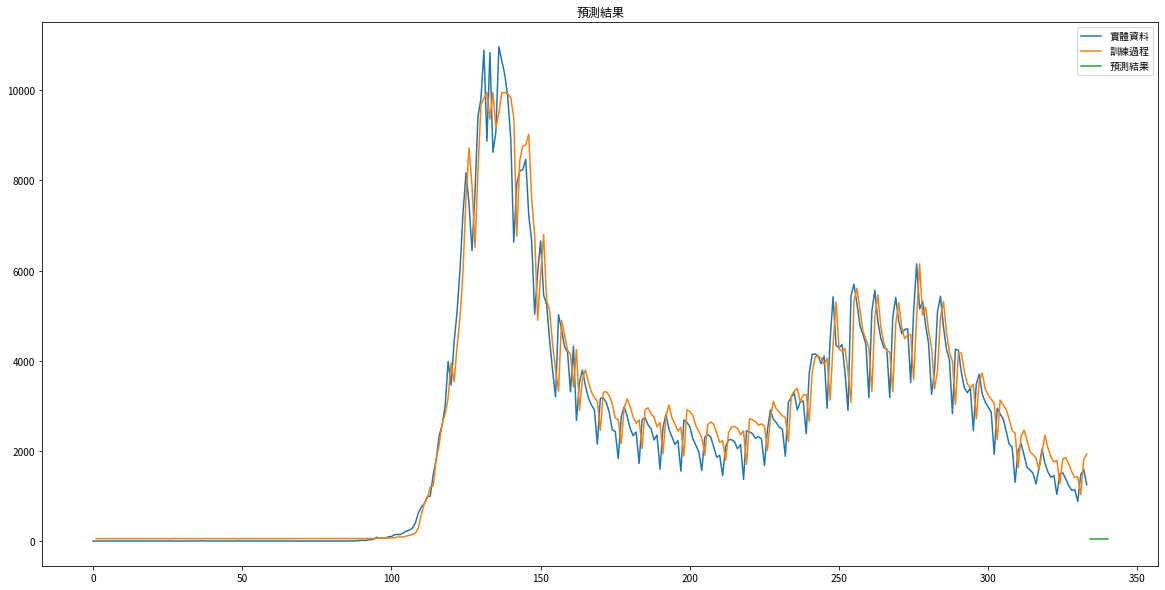

In [42]:
plt.figure(figsize=(20,10))
plt.title('預測結果')
plt.plot(dataset_ori,label='實體資料')
plt.plot(trainPredictPlot,label='訓練過程')
plt.plot(testPredictPlot,label='預測結果')
plt.legend()
plt.show()